In [3]:
import scanpy as sc
import pandas as pd

In [4]:
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/vascular_normal_master.h5ad")

In [11]:
# Add raw layer
adata.layers['counts'] = adata.raw.X

In [12]:
adata.obs.donor_id

AAACGAAAGACTCATC-1     patient1
AAACGAACAACGACTT-1     patient1
AAACGAACAATCGCCG-1     patient1
AAACGCTCAGCAGGAT-1     patient1
AAACGCTTCCGTGTCT-1     patient1
                         ...   
TTTGTTGCAATAAGGT-39    patient6
TTTGTTGCACCAGTAT-39    patient6
TTTGTTGGTAACGCGA-39    patient6
TTTGTTGGTACGTGAG-39    patient6
TTTGTTGGTGAGTCAG-39    patient6
Name: donor_id, Length: 113304, dtype: category
Categories (6, object): ['patient1', 'patient2', 'patient3', 'patient4', 'patient5', 'patient6']

In [13]:
adata.obs.cell_type

AAACGAAAGACTCATC-1                                         macrophage
AAACGAACAACGACTT-1                                         macrophage
AAACGAACAATCGCCG-1     microcirculation associated smooth muscle cell
AAACGCTCAGCAGGAT-1                                         fibroblast
AAACGCTTCCGTGTCT-1                                         macrophage
                                            ...                      
TTTGTTGCAATAAGGT-39                                        fibroblast
TTTGTTGCACCAGTAT-39                                        fibroblast
TTTGTTGGTAACGCGA-39                                        fibroblast
TTTGTTGGTACGTGAG-39                   blood vessel smooth muscle cell
TTTGTTGGTGAGTCAG-39                   blood vessel smooth muscle cell
Name: cell_type, Length: 113304, dtype: category
Categories (7, object): ['fibroblast', 'macrophage', 'lymphocyte', 'microcirculation associated smooth muscle cell', 'blood vessel smooth muscle cell', 'endothelial cell of artery',

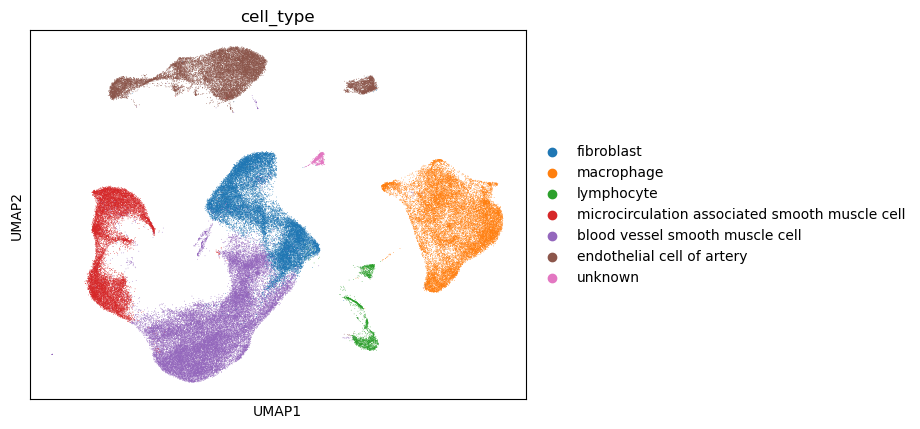

In [14]:
sc.pl.umap(adata, color = 'cell_type')

## Filter data
- one donor (patient 1)
- two cell types (macrophage, fibroblast)

In [15]:
adata_sub = adata[(adata.obs.cell_type.isin(['macrophage', 'fibroblast'])) & (adata.obs.donor_id == 'patient1')]

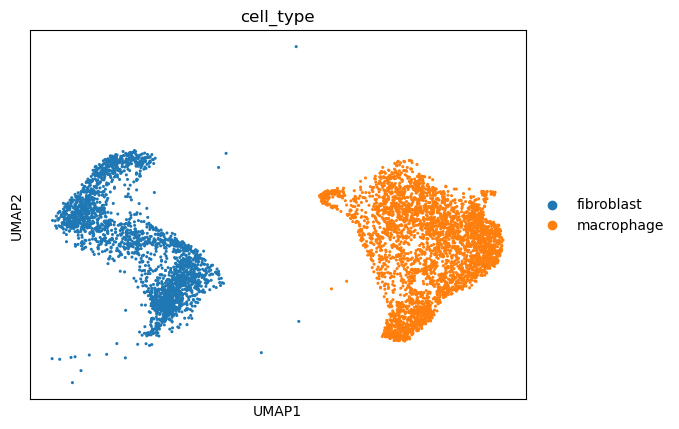

In [16]:
sc.pl.umap(adata_sub, color = 'cell_type')

In [17]:
adata.var

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000243485,True,MIR1302-2HG,NCBITaxon:9606,gene,623,lncRNA
ENSG00000237613,True,FAM138A,NCBITaxon:9606,gene,888,lncRNA
ENSG00000186092,True,OR4F5,NCBITaxon:9606,gene,2618,protein_coding
ENSG00000238009,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA
ENSG00000239945,False,ENSG00000239945.1,NCBITaxon:9606,gene,1319,lncRNA
...,...,...,...,...,...,...
ENSG00000277856,True,ENSG00000277856.1,NCBITaxon:9606,gene,294,protein_coding
ENSG00000275063,True,ENSG00000275063.1,NCBITaxon:9606,gene,351,protein_coding
ENSG00000271254,False,ENSG00000271254.7,NCBITaxon:9606,gene,2922,protein_coding
ENSG00000277475,True,ENSG00000277475.1,NCBITaxon:9606,gene,831,protein_coding


In [18]:
# Remove genes that have been filtered
adata_sub_filtered = adata_sub[:, adata_sub.var['feature_is_filtered']== False]

In [19]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata_sub_filtered, inplace=True)

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [22]:
adata_sub_filtered.var['total_counts'].mean()

891.75507

In [21]:
adata_sub_filtered.var

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000238009,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA,40,0.002678,0.002675,99.353169,16.561602,2.865715
ENSG00000239945,False,ENSG00000239945.1,NCBITaxon:9606,gene,1319,lncRNA,4,0.000240,0.000240,99.935317,1.482688,0.909342
ENSG00000237491,False,LINC01409,NCBITaxon:9606,gene,1059,lncRNA,391,0.030694,0.030233,93.677232,189.814697,5.251303
ENSG00000177757,False,FAM87B,NCBITaxon:9606,gene,1947,lncRNA,44,0.003231,0.003226,99.288486,19.980288,3.043583
ENSG00000225880,False,LINC00115,NCBITaxon:9606,gene,3312,lncRNA,167,0.013537,0.013446,97.299483,83.714722,4.439290
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278817,False,ENSG00000278817.1,NCBITaxon:9606,gene,1213,protein_coding,351,0.025161,0.024850,94.324062,155.596588,5.053673
ENSG00000277196,False,ENSG00000277196.4,NCBITaxon:9606,gene,2197,protein_coding,2,0.000107,0.000107,99.967658,0.664546,0.509553
ENSG00000278384,False,ENSG00000278384.1,NCBITaxon:9606,gene,3027,protein_coding,63,0.004674,0.004663,98.981242,28.904743,3.398017
ENSG00000276345,False,ENSG00000276345.1,NCBITaxon:9606,gene,740,protein_coding,1746,0.147193,0.137319,71.765847,910.245239,6.814812


In [92]:
adata_sub_filtered.var['n_cells_by_counts'].mean()

1066.097903324853

In [93]:
adata_sub_filtered.obs['total_counts'].mean()

3287.5535

## Add genomic positions

In [94]:

def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
 
    '''

    
    # Load the gene positions data
    gene_file = "/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt"
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

In [95]:
add_genomic_positions(adata_sub_filtered)

22015 gene positions identified 
783 were not found


AnnData object with n_obs × n_vars = 6184 × 22798
    obs: 'mapped_reference_annotation', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'donor_BMI_at_collection', 'tissue_type', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_

In [96]:
adata_sub_filtered.write("/home/augusta/SSS_mount/insituCNV/data/vascular_normal.h5ad", compression = 'gzip')